*Sergey Tomin (sergey.tomin@desy.de). June 2025.*

# [Lattice Energy Profile](https://github.com/ocelot-collab/ocelot/blob/master/ocelot/cpbd/physics_proc.py#L624)

The `LatticeEnergyProfile` class is a physics process used in Ocelot simulations to adjust the reference energy (`Eref`) of a `ParticleArray`. It then recalculates the canonical momentum `p = (E_particle - Eref) / p0c` for all particles relative to this new reference energy.

This is particularly useful in scenarios where the actual energy of the beam deviates from the design energy for which a section of the accelerator lattice (e.g., magnets) is configured. By using `LatticeEnergyProfile`, one can simulate the effect of particles with a certain energy traversing magnetic elements that are effectively "set" for a different reference energy.

**Key Points:**
-   It changes the `ParticleArray.E` attribute (the reference energy).
-   It recalculates the 6th phase space coordinate (`p`) of each particle to be consistent with the new reference energy.
-   **Crucially, the actual physical energy of each particle (`E_particle`) remains unchanged by this process.** Only its representation relative to `Eref` is modified.

---

## LatticeEnergyProfile Class

Modifies a `ParticleArray`'s reference energy (`Eref`) and updates the canonical momentum of particles accordingly.

### How it Works
The canonical momentum `p` for a particle is defined as:
`p = (E_particle - Eref) / p0c`
where:
- `E_particle` is the actual energy of the particle.
- `Eref` is the reference energy of the `ParticleArray`.
- `p0c = sqrt(Eref^2 - m_e_GeV^2)` is the reference momentum corresponding to `Eref`.

When `LatticeEnergyProfile` is applied with a new `Eref_new`:
1. The old particle energy `E_particle` is preserved:
   `E_particle = p_old * p0c_old + Eref_old`
2. The new canonical momentum `p_new` is calculated using `Eref_new`:
   `p_new = (E_particle - Eref_new) / p0c_new`
   Substituting `E_particle`:
   `p_new = ( (p_old * p0c_old + Eref_old) - Eref_new ) / p0c_new`
3. The `ParticleArray`'s reference energy is updated: `p_array.E = Eref_new`.
4. The particles' canonical momenta are updated: `p_array.p()[:] = p_new`.


### Parameters:
-   **Eref** (`float`): The new reference energy in GeV to which the `ParticleArray`'s reference will be set.

### Methods:

#### `__init__(self, Eref)`
Constructor for the `LatticeEnergyProfile` class.
-   `Eref` (`float`): The target reference energy in GeV.
Initializes the process and stores `Eref`. It also calls the parent class (`PhysProc`) initializer.

#### `apply(self, p_array, dz=0)`
Applies the reference energy shift to the given particle array (`p_array`).
-   `p_array` ([`ParticleArray`](../beam/particle-array)): The particle array to be modified.
-   `dz` (`float`, optional): Path length, typically unused by this process.

This method performs the recalculation of canonical momenta as described in "How it Works".

---

## Example Usage

### Basic Application
This example shows how to change the reference energy of a `ParticleArray` and demonstrates that the actual mean energy of the particles is conserved.


In [4]:
from ocelot.cpbd.beam import ParticleArray, generate_parray
from ocelot.cpbd.physics_proc import LatticeEnergyProfile
from ocelot.common.globals import m_e_GeV
import numpy as np

# Initial reference energy
E_initial_ref = 0.5  # GeV

# Create a particle array with some energy spread
# For this example, let's use generate_parray to create a realistic beam
# Note: generate_parray sets the ParticleArray.E to the specified energy
parray = generate_parray(energy=E_initial_ref, sigma_p=0.001, nparticles=1000)
print(f"Initial ParticleArray E (reference): {parray.E:.4f} GeV")

# Calculate initial mean physical energy of particles
p0c_initial = np.sqrt(parray.E**2 - m_e_GeV**2)
mean_E_physical_initial = np.mean(parray.p() * p0c_initial + parray.E)
print(f"Initial mean physical particle energy: {mean_E_physical_initial:.4f} GeV")
print(f"Initial mean p coordinate: {np.mean(parray.p()):.4e}\n")

# Define the new reference energy
E_new_ref = 0.505  # GeV

# Create LatticeEnergyProfile instance
lep = LatticeEnergyProfile(Eref=E_new_ref)

# Apply the process
lep.apply(parray)

print(f"Updated ParticleArray E (new reference): {parray.E:.4f} GeV")

# Calculate new mean physical energy of particles
p0c_new = np.sqrt(parray.E**2 - m_e_GeV**2)
mean_E_physical_new = np.mean(parray.p() * p0c_new + parray.E)
print(f"Updated mean physical particle energy: {mean_E_physical_new:.4f} GeV")
print(f"Updated mean p coordinate: {np.mean(parray.p()):.4e}\n")

# Verify that the physical energy is conserved
assert np.isclose(mean_E_physical_initial, mean_E_physical_new), \
    "Mean physical energy should be conserved!"
print("Assertion passed: Mean physical energy is conserved.")

Initial ParticleArray E (reference): 0.5000 GeV
Initial mean physical particle energy: 0.5001 GeV
Initial mean p coordinate: 1.3081e-04

Updated ParticleArray E (new reference): 0.5050 GeV
Updated mean physical particle energy: 0.5001 GeV
Updated mean p coordinate: -9.7715e-03

Assertion passed: Mean physical energy is conserved.


This shows that while `parray.E` (the reference energy) and `parray.p()` (canonical momentum) change, the actual average energy of the particles remains the same.

### Simulating Fixed Magnet Settings with Beam Energy Jitter

A common use case is to simulate how a beam with an off-nominal energy behaves in a lattice designed for a nominal energy. Magnets (quadrupoles, bends) in Ocelot typically use the `ParticleArray.E` attribute as their reference energy. If the beam's actual energy drifts but `ParticleArray.E` is also updated to this drifted energy, the magnets would "implicitly retune" themselves, which is not realistic.

The `LatticeEnergyProfile` allows you to set `ParticleArray.E` to the *design* energy of the magnets right before tracking through them, even if the particles themselves have a different average physical energy (e.g., due to RF phase/voltage errors).

Consider a simplified scenario:
1.  Beam is accelerated in a cavity. Due to jitter, its final energy `E_actual` is slightly different from the design energy `E_design`.
2.  The beam then enters a FODO cell designed for `E_design`.

**Important Considerations:**

*   **Observing Energy-Dependent Effects:**
    In quadrupoles, first-order transverse dynamics are generally independent of particle energy. Therefore, to observe the differences caused by an energy mismatch (where `E_actual` deviates from `E_design`) and thus see the impact of using `LatticeEnergyProfile`, you typically need to enable second-order calculations. Without this, the chromatic effects that `LatticeEnergyProfile` helps to model might not be apparent in the transverse dynamics from quadrupoles.

*   **Magnitude of Energy Difference:**
    The difference between the actual beam energy (`E_actual`) and the design reference energy (`E_design` set by `LatticeEnergyProfile`) should not be excessively large. Ocelot's transfer matrices for elements like quadrupoles, dipoles etc. are often expanded to a certain order (e.g., up to second order). If the energy deviation is too significant, higher-order effects not included in these models might become important, potentially reducing the accuracy of the simulation. While a precise limit isn't strictly defined, keeping the energy difference within a few percent is a common guideline for obtaining reasonably accurate results with such models.


[INFO    ] Twiss parameters have priority. sigma_{x, px, y, py} will be redefined


Beam energy before tracking cavity (Case 1): 0.0050 GeV
z = 2.2 / 2.2. Applied: Beam reference energy after FODO (Case 1): 0.1250 GeV

Beam energy before tracking cavity (Case 2): 0.0050 GeV
z = 2.2 / 2.2. Applied: Beam reference energy after FODO (Case 2): 0.1300 GeV
Case 1 (FODO entrance): Ref E = 0.125, Actual mean E ~ 0.125
Case 2 (FODO entrance): Ref E = 0.13, Actual mean E ~ 0.125


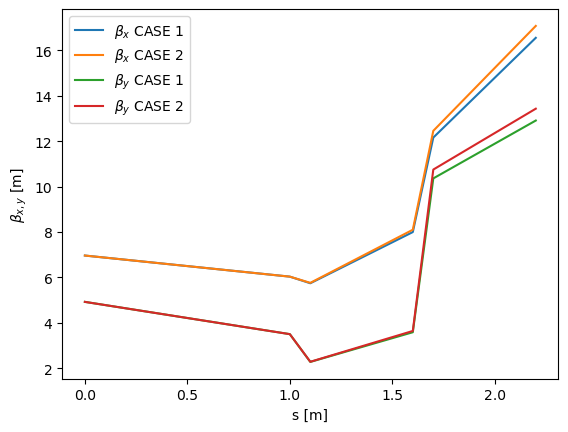

In [23]:
from ocelot import MagneticLattice, Drift, Quadrupole, Cavity, Navigator, Marker, SecondTM
from ocelot.cpbd.beam import Twiss, generate_parray
from ocelot.cpbd.track import track
from ocelot.cpbd.physics_proc import LatticeEnergyProfile
import matplotlib.pyplot as plt
# (Assuming necessary plotting imports if you want to visualize)

# --- Beam and Lattice Setup ---
E_design_gun = 0.005 # GeV
tws_initial = Twiss(beta_x=7, beta_y=5, emit_xn=0.5e-6, emit_yn=0.5, E=E_design_gun) # Simplified Twiss
# ... (set other tws_initial parameters if needed for a full run)
initial_parray = generate_parray(sigma_tau=0.001, sigma_p=1e-4, charge=100e-12, tws=tws_initial)

E_design_linac_exit = 0.130 # 130 MeV
E_actual_linac_exit = 0.125 # Actual energy due to jitter (e.g. 125 MeV)

# Simulated cavity that gives slightly less energy
cav = Cavity(l=1.0, v=(E_actual_linac_exit - E_design_gun), freq=1.3e9, phi=0) # simplified voltage
# cav.v is V_eff = E_gain / q_e

# Marker after cavity, before FODO
m_cav_exit = Marker("CAV_EXIT")

# FODO designed for E_design_linac_exit
qf = Quadrupole(l=0.1, k1=2.0, eid="QF") # k1 depends on E_design
qd = Quadrupole(l=0.1, k1=-2.0, eid="QD")
dr = Drift(l=0.5)
fodo_cell = (m_cav_exit, qf, dr, qd, dr)

# Full lattice: gun energy section -> cavity -> FODO
lat = MagneticLattice((cav,) + fodo_cell, method={"global":SecondTM}) 

# --- Case 1: No LatticeEnergyProfile (Implicit magnet retuning) ---
# Set the parray's E to the actual energy. Magnets will scale based on this.
p_array_case1 = initial_parray.copy()
# track through cavity, p_array_case1.E will be updated by cavity
# For simplicity in this example snippet, we assume p_array_case1 has E_actual_linac_exit AFTER cavity.
# In a real track, the cavity itself updates parray.E if p_array.E is near particle energy.
# If E_actual is very different, this gets complex without LEP even for cavity.
# Let's assume after the cavity, the p_array.E reflects E_actual_linac_exit
print(f"Beam energy before tracking cavity (Case 1): {p_array_case1.E:.4f} GeV")
# Simulate cavity effect roughly on reference energy for simplicity of this snippet.
# In a full track(), cavity updates .E
# If you track part by part, this needs manual care or specific cavity flags.
# Here we'll just track through lattice assuming cavity updated parray.E correctly
# and then for FODO, if p_array_case1.E is E_actual_linac_exit, magnets scale.
# We will use the fact that tracking a cavity updates p_array.E
twiss_track_case1, p_array_tracked_case1 = track(lat, p_array_case1, Navigator(lat))
print(f"Beam reference energy after FODO (Case 1): {p_array_tracked_case1.E:.4f} GeV")
# The FODO quadrupoles (qf, qd) effectively "saw" a beam with E_actual_linac_exit
# and their k1 values were interpreted against this energy.

# --- Case 2: With LatticeEnergyProfile (Magnets see E_design) ---
p_array_case2 = initial_parray.copy()

nav = Navigator(lat)
# After the cavity (m_cav_exit), force the reference energy to E_design_linac_exit
# so subsequent magnets (FODO) act as if beam has E_design_linac_exit
lep_fodo = LatticeEnergyProfile(Eref=E_design_linac_exit)
nav.add_physics_proc(lep_fodo, m_cav_exit, m_cav_exit)

print(f"\nBeam energy before tracking cavity (Case 2): {p_array_case2.E:.4f} GeV")
twiss_track_case2, p_array_tracked_case2 = track(lat, p_array_case2, nav)
print(f"Beam reference energy after FODO (Case 2): {p_array_tracked_case2.E:.4f} GeV")
# The cavity accelerates the beam, and its real energy will be ~E_actual_linac_exit.
# The `lep_fodo` process then changes `p_array_case2.E` to `E_design_linac_exit`.
# So, qf and qd act on particles as if the reference design energy is E_design_linac_exit,
# even though the particles' physical energies are centered around E_actual_linac_exit.
# The final parray.E from track() will be E_design_linac_exit due to the last LEP application.
# If you print p_array_tracked_case2.get_mean_energy(), it will be around E_actual_linac_exit.

# To verify (conceptual):
print(f"Case 1 (FODO entrance): Ref E = {E_actual_linac_exit}, Actual mean E ~ {E_actual_linac_exit}")
print(f"Case 2 (FODO entrance): Ref E = {E_design_linac_exit}, Actual mean E ~ {E_actual_linac_exit}")

# plot Twiss paramteters for two casses 
s = [tw.s for tw in twiss_track_case1]
bx1 = [tw.beta_x for tw in twiss_track_case1]
by1 = [tw.beta_y for tw in twiss_track_case1]
bx2 = [tw.beta_x for tw in twiss_track_case2]
by2 = [tw.beta_y for tw in twiss_track_case2]

plt.plot(s, bx1, label=r"$\beta_x$ CASE 1")
plt.plot(s, bx2, label=r"$\beta_x$ CASE 2")
plt.plot(s, by1, label=r"$\beta_y$ CASE 1")
plt.plot(s, by2, label=r"$\beta_y$ CASE 2")
plt.legend()
plt.xlabel("s [m]")
plt.ylabel(r"$\beta_{x,y}$ [m]")
plt.show()

In Case 2, the `LatticeEnergyProfile` ensures that the FODO cell quadrupoles apply kicks calculated based on `E_design_linac_exit`, correctly simulating their fixed settings, while the particles traverse them with an average physical energy of `E_actual_linac_exit`.

---

## Summary

The `LatticeEnergyProfile` class is an essential tool for accurately simulating beam dynamics in accelerators where the beam's energy may vary from the design energy of specific lattice sections. It allows the user to define fixed reference energies for lattice segments, ensuring that magnetic elements behave as per their design specifications irrespective of incoming beam energy fluctuations. This is crucial for studying effects like RF jitter, energy ramps, or modeling sections with different design energies.

For a detailed tutorial demonstrating the simulation of RF jitter using `LatticeEnergyProfile`, please see:
Energy Jitter Simulation Tutorial.